<a href="https://colab.research.google.com/github/swapnilmn/Assignment_1_CS6910/blob/master/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Question 3 (24 Marks) Implement the backpropagation algorithm with support for the following optimisation functions
            sgd
            momentum based gradient descent
            nesterov accelerated gradient descent
            rmsprop
            adam
            nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

# Libraries 

In [1]:
from keras.datasets import fashion_mnist, mnist
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from sklearn.model_selection import train_test_split 
import pandas as pd
import subprocess
subprocess.call(['pip', 'install', 'wandb'])
import wandb
wandb.login()
import numpy as np

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data Processing

In [7]:
class OneHotEncoder_from_scratch:
    
    def __init__(self):
        self.categories = None
    def fit(self, X):
        self.categories =[]
        for i in range(X.shape[1]):
            feature_categories =list(set(X[:, i]))
            self.categories.append(feature_categories)
            
    def transform(self, X):
        one_hot_vector = []

        for i in range(X.shape[0]):
            one_hot_row = []
            for j in range(X.shape[1]):

                category_index = self.categories[j].index(X[i, j])
                category_one_hot =[0] *len(self.categories[j])
                category_one_hot[category_index] = 1

                one_hot_row.extend(category_one_hot)
            one_hot_vector.append(one_hot_row)
        return np.array(one_hot_vector)

In [8]:
def dataset_type(dataset = 'fashion_mnist'):
  if dataset == 'fashion_mnist':
      (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
  elif dataset == 'mnist':
      (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
  else:
      raise ValueError('Invalid dataset name')
  X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)
  # Flatten input images
  train_input = X_train.reshape((X_train.shape[0], -1))
  test_input =test_images.reshape((test_images.shape[0], -1))
  val_input = X_val.reshape((X_val.shape[0], -1))

  Y_train = np.array(Y_train)
  Y_val = np.array(Y_val)
  Y_test= np.array(test_labels)

  X_train =np.array(train_input) / 255.0
  X_test = np.array(test_input) / 255.0
  X_val = np.array(val_input) / 255.0

  enc = OneHotEncoder_from_scratch()
  enc.fit(Y_train.reshape(-1, 1))
  Y_train = enc.transform(Y_train.reshape(-1, 1))
  Y_val = enc.transform(Y_val.reshape(-1, 1))
  Y_test = enc.transform(Y_test.reshape(-1, 1))

  return X_train, X_val, X_test, Y_train, Y_val, Y_test

X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset_type(dataset = 'fashion_mnist')
# print(Y_train.shape, Y_val.shape, Y_test.shape)
# print(X_train.shape, X_val.shape, X_test.shape)

# Class of FeedForward Neural Network

accuracy,▂▂▂▂▄▄▄▄▄▁▇▇▇▇▄▁▂▄▄▄▂▂▂▂▄▄▄▇▆▁███▄▄▃▂▄▄▄
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁██████▁▁▁▁▁▇▇▇███▁▁▁▁▁██▇▇▇█▁▁▁▁▁▁
val_accuracy,▂▂▂▂▄▄▄▄▄▁▇▇▇▇▄▁▂▄▄▄▂▂▂▂▄▄▄▇▆▁███▄▄▃▂▄▃▃
val_loss,█▁▁▁▁▁██████▁▁▁▁▁▇▇▇███▁▁▁▁▁██▇▇▇█▁▁▁▁▁▁
accuracy,0.24128
epoch,1
loss,0.0415
val_accuracy,0.2355
val_loss,0.04155


  0%|          | 0/19 [00:00<?, ?epoch/s]

Epoch: 1, Train Loss: 0.14375178893550167, Train Accuracy: 0.816462962962963, Val Loss: 0.14406309985437274, Val Accuracy: 0.814
Epoch: 2, Train Loss: 0.13871085786611245, Train Accuracy: 0.8629629629629629, Val Loss: 0.13915129526178374, Val Accuracy: 0.8578333333333333
Epoch: 3, Train Loss: 0.13685668587977784, Train Accuracy: 0.8811481481481481, Val Loss: 0.13772871296134098, Val Accuracy: 0.8708333333333333
Epoch: 4, Train Loss: 0.13576469613845576, Train Accuracy: 0.8903888888888889, Val Loss: 0.13699621039172633, Val Accuracy: 0.8785
Epoch: 5, Train Loss: 0.1350157919087659, Train Accuracy: 0.8977407407407407, Val Loss: 0.13652787335775698, Val Accuracy: 0.8828333333333334
Epoch: 6, Train Loss: 0.1344300839140759, Train Accuracy: 0.9027592592592593, Val Loss: 0.13622680303411963, Val Accuracy: 0.8868333333333334
Epoch: 7, Train Loss: 0.13397770163950254, Train Accuracy: 0.9073703703703704, Val Loss: 0.13603642399392984, Val Accuracy: 0.8878333333333334
Epoch: 8, Train Loss: 0.133

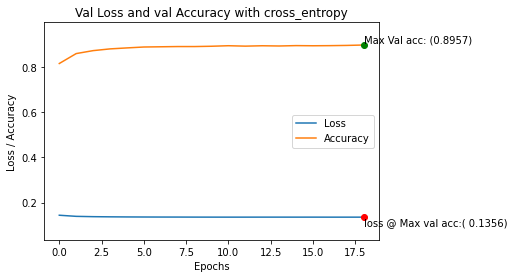

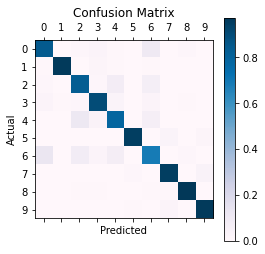

In [18]:
wandb.init(project = 'Question_4_Best_Model', entity = 'ed22s009')
class FFNN:
  def __init__(self, X, Y,
               epochs=100, 
               hidden_layer_count=4,
               hidden_layers=[32, 64, 128, 256],
               learning_rate=0.001,
               batch_size=32,
               activation='tanh',
               weight_init='random',
               loss='mean_squared_error',
               weight_decay=0):
    
    self.params = {
      'inputs': X.shape[1],
      'outputs': Y.shape[1],
      'epochs': epochs,
      'hidden_layers': hidden_layer_count,
      'network_size': [X.shape[1]] + hidden_layers +[Y.shape[1]],
      'learning_rate': learning_rate,
      'batch_size': batch_size,
      'weights': {},
      'weight_init': weight_init,
      'activation_function':activation,
      'loss_function': loss,
      'lambd': weight_decay
    }

    self.update(self.params)
    np.random.seed(0)

  def update(self, params):
    for key, value in params.items():
      setattr(self, key, value)

    self.grad_derivatice={}
    self.u_w = {f'{key}{i}': 0 for i in range(1, self.hidden_layers+1) for key in ['vw','vb', 'mb', 'mw']}
    self.p_u_w = {f'{key}{i}': 0 for i in range(1, self.hidden_layers+1) for key in ['vw', 'vb', 'mb', 'mw']}

    # for creating initial weights
    if self.weight_init == 'random':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1], self.network_size[i])
          weight_scale = 0.1
          np.random.seed(0) # including random seet fpr reproducibilty
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale, size=weight_shape)*0.1
          # we are mulliplying ny 0.1 to get less wrights
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)

    if self.weight_init == 'Xavier':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1],self.network_size[i])
          weight_scale = 0.1
          np.random.seed(0)
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale,size=weight_shape)*np.sqrt(1/self.network_size[i-1])
          # we are mulliplying ny 0.1 to get less wrights
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)



  def forward_activation(self, X):
      # Define a dictionary of activation functions and their corresponding lambda functions
    activation_functions = {
        'sigmoid': lambda x: 1.0 / (1.0 + np.exp(-x)), # sigmoid activation function
        'tanh': np.tanh, # hyperbolic tangent activation function
        'ReLU': lambda x: np.maximum(0, x) # rectified linear unit (ReLU) activation function
    }
    # Get the activation function based on the value of `self.activation_function`
    activation_function = activation_functions.get(self.activation_function)
    # If the activation function is found, apply it to the input matrix `X`
    if activation_function:
        return activation_function(X)
    # If the activation function is not found, raise a ValueError indicating that it is unknown
    else:
        raise ValueError(f"Unknown activation function '{self.activation_function}'")



  def grad_activation(self, X):
    # Define a dictionary of activation function derivatives and their corresponding lambda functions
    activation_gradients = {
        'sigmoid': lambda x: x * (1 - x), # derivative of the sigmoid activation function
        'tanh': lambda x: 1 - np.square(x), # derivative of the hyperbolic tangent activation function
        'ReLU': lambda x: 1.0 * (x > 0) # derivative of the rectified linear unit (ReLU) activation function
    }
    # Get the derivative of the activation function based on the value of `self.activation_function`
    gradient_function = activation_gradients.get(self.activation_function)
    # If the derivative function is found, apply it to the input matrix `X`
    if gradient_function:
        return gradient_function(X)
    # If theerivative function is not found, raise a alueError indicating that it is unknown
    else:
        raise ValueError(f"Unknown activation function '{self.activation_function}'")


  def softmax(self, X):
    exps =np.exp(X - np.max(X, axis=1, keepdims=True)) # to reduce long numbers
    return  exps /np.sum(exps, axis=1, keepdims=True)


  def forward_pass(self, X, weights=None):
    # X: shape (batch_size, input_dim)
    if weights is None:
        weights = self.weights

    # Initialize dictionaries to store intermediate outputs
    self.z = {}
    self.h = {}
    self.h[0] = X

    # Perform forward pass through hidden layers
    for i in range(self.hidden_layers):
        # Compute weighted sum of inputs and biases
        z_i = self.h[i] @ weights[f'W{i+1}']
        z_i = z_i + weights[f'B{i+1}']
        self.z[i+1] = z_i
        # Apply activation function
        h_i = self.forward_activation(z_i)
        self.h[i+1] = h_i

    # Compute final output
    z_final = self.h[self.hidden_layers] @ weights[f'W{self.hidden_layers+1}']
    z_final = z_final + weights[f'B{self.hidden_layers+1}']
    self.z[self.hidden_layers+1] = z_final

    # Apply softmax activation functionto final output
    h_final = self.softmax(z_final)
    self.h[self.hidden_layers+1] = h_final
    # Return final output
    return h_final

  def backprop(self, X, Y, weights=None):
    #X(batch_size, input_size)
    #Y(batch_size, output_size)
    if weights is None:
        weights = self.weights
    # Perform forward pass
    self.forward_pass(X, weights)
    # Initialize dictionary to storegradients
    self.grad_derivatice = {}
    total_layers = self.hidden_layers + 1
    # Calculate gradients for output layer based on the selected loss function
    if self.loss_function == 'cross_entropy':
        self.grad_derivatice[f'dA{total_layers}'] = (self.h[total_layers] -Y)
    elif self.loss_function == 'mean_squared_error':
        self.grad_derivatice[f'dA{total_layers}'] = (1/X.shape[0]) * 2 * (self.h[total_layers] - Y)

    # Loop through hidden layers in reverse order andalculate gradients
    for k in range(total_layers, 0, -1):
        # Define keys for weightsiases, and gradients
        w_key, b_key, dw_key, db_key, da_key = [f'{key}{k}' for key in ['W', 'B', 'dW', 'dB', 'dA']]
        # Calculate gradients for weights
        dw = np.matmul(self.h[k-1].T, self.grad_derivatice[da_key])
        dw_reg = dw+ self.lambd *weights[w_key]
        self.grad_derivatice[dw_key] = dw_reg
        # Calculate gradients forbiases
        db = np.sum(self.grad_derivatice[da_key], axis=0).reshape(1, -1)
        db_reg = db + self.lambd * weights[b_key]
        self.grad_derivatice[db_key] = db_reg
        # Calculategradient for previous layer's output
        dH = np.matmul(self.grad_derivatice[da_key], weights[w_key].T)
        self.grad_derivatice[f'dH{k-1}'] = dH
        # Calculate gradient for previous layer'sactivation
        dA = np.multiply(dH, self.grad_activation(self.h[k-1]))
        self.grad_derivatice[f'dA{k-1}'] =dA
        # Calculate gradient for regularizationterm
        reg_grad = self.lambd *weights[w_key]
        self.grad_derivatice[f'dW_reg{k}'] = reg_grad
    # Add regularization gradient to gradients for weights
    for k in range(1, total_layers+1):
        dw_key, dw_reg_key = [f'{key}{k}' for key in ['dW', 'dW_reg']]
        self.grad_derivatice[dw_key] += self.grad_derivatice[dw_reg_key]
        # dw_key, dw_reg_key = [f'{key}{k}' for key in ['dW']]
        # self.grad_derivatice[dw_key] = self.grad_derivatice[dw_reg_key]
    # Return gradient for previous layer's output
    return self.grad_derivatice[f'dH{k-1}']


  def fit(self, X, Y, X_val, Y_val,algo= 'GD',a = 10, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9, show_loss = False):
    #X(batch_size, input_size)
    #Y(batch_size, output_size)
    if show_loss:
      los = []
      accuracy = []
    for num_epoch in tqdm(range(1, self.epochs+1), unit='epoch'):
      m = X.shape[0]
      
      if algo == 'sgd':
          # Loop over the number of samples
          for i in range(m):
              # Select a random sample
              rand_idx = np.random.randint(m)
              x_i = X[rand_idx:rand_idx+1]
              y_i = Y[rand_idx:rand_idx+1]

              # Perform backpropagation on the sample
              self.backprop(x_i, y_i)

              # Loop over the hidden layers
              for j in range(1, self.hidden_layers+1):
                  # Get the keys for the weights, biases, and gradients
                  w_key, b_key, dw_key, db_key = [f'{key}{j}' for key in ['W', 'B', 'dW', 'dB']]
                  # w_key(prev_layer_output_dim,layer_output_dim)
                  # b_key1,layer_output_dim)
                  # dw_key(prev_layer_output_dim,layer_output_dim)
                  # db_key(1,layer_output_dim)

                  # Update the weights and biases using the gradients
                  self.weights[w_key] -= self.learning_rate * self.grad_derivatice[dw_key]
                  self.weights[b_key] -= self.learning_rate * self.grad_derivatice[db_key]
                  # self.weights[w_key] -= self.learning_rate * self.grad_derivatice[dw_key]/m
                  # self.weights[b_key] -= self.learning_rate * self.grad_derivatice[db_key]/m

          # Log the results for this epoch
          self.wandlog(num_epoch, X, Y, X_val, Y_val)

      
      elif algo == 'momentum':
          num_examples = X.shape[0]
          num_batches = num_examples // self.batch_size
          gamma = 0.9  
          for batch in range(num_batches + 1):
              start_index = batch * self.batch_size
              end_index = min((batch + 1) * self.batch_size, num_examples)
              X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

              self.backprop(X_batch, Y_batch)

              for i in range(1, self.hidden_layers + 1):
                  w_key, b_key, vw_key, vb_key, dw_key, db_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                  # w_key(prev_layer_output_dim,layer_output_dim)
                  # b_key1,layer_output_dim)
                  # dw_key(prev_layer_output_dim,layer_output_dim)
                  # db_key(1,layer_output_dim)

                  self.u_w[vw_key] = gamma * self.u_w[vw_key] + self.learning_rate * self.grad_derivatice[dw_key]
                  self.u_w[vb_key] = gamma * self.u_w[vb_key] + self.learning_rate * self.grad_derivatice[db_key]
                  grad_dw = self.grad_derivatice[dw_key] + gamma * self.u_w[vw_key]
                  grad_db = self.grad_derivatice[db_key] + gamma * self.u_w[vb_key]

                  # Update weights and biases
                  self.weights[w_key] -= self.learning_rate * grad_dw
                  self.weights[b_key] -= self.learning_rate * grad_db

              # Log the loss and accuracy after every N steps
          self.wandlog(num_epoch, X, Y, X_val, Y_val)


      
      elif algo == 'rmsprop':
          num_examples =X.shape[0]
          num_batches = num_examples//self.batch_size

          for batch in range(num_batches + 1):
              start_index = batch *self.batch_size
              end_index = min((batch+1)*self.batch_size, num_examples)
              X_batch, Y_batch = X[start_index:end_index],Y[start_index:end_index]
              # X_batch, Y_batch = X[start_index:end_index],Y[start_index:0]
              self.backprop(X_batch, Y_batch)

              for i in range(1, self.hidden_layers+1):
                  w_key, b_key, vw_key, vb_key, dw_key, db_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                  # The shape of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                  # The shape of the bias matrix for this layer (1, layer_output_dim)
                  # The shape of the gradient of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                  # The shape of the gradient of the bias matrix for this layer (1, layer_output_dim)
                  prev_layer_output_dim = self.weights[f'{w_key}'].shape[0]
                  layer_output_dim = self.weights[f'{w_key}'].shape[1]

                  # Compute gradients for this layer

                  dW, dB = self.grad_derivatice[dw_key],self.grad_derivatice[db_key]
                  dw_squared =np.square(dW)
                  db_squared= np.square(dB)

                  # self.u_w[vw_key] = beta *self.u_w[vw_key] + (1 - beta)
                  # self.u_w[vb_key] =beta* self.u_w[vb_key]+ (1 - beta)

                  # Update the exponentially weighted averages of the squared gradients
                  self.u_w[vw_key] =beta*self.u_w[vw_key] +(1 -beta) *dw_squared
                  self.u_w[vb_key] =beta* self.u_w[vb_key]+(1- beta)* db_squared

                  # Compute the RMSProp update for the weights and biases
                  dw_rms = np.sqrt(self.u_w[vw_key] + 1e-8)
                  db_rms = np.sqrt(self.u_w[vb_key] + 1e-8)
                  # Updating weights
                  dw_update = (self.learning_rate / dw_rms) * dW
                  db_update = (self.learning_rate / db_rms) * dB

                  # Update the weights and biases
                  self.weights[w_key] -= dw_update
                  self.weights[b_key] -= db_update

          self.wandlog(num_epoch, X, Y, X_val, Y_val)
      
      elif algo == 'adam':
          num_examples = X.shape[0]
          num_batches = num_examples //self.batch_size

          for batch in range(num_batches + 1):
              start_index = batch *self.batch_size
              end_index = min((batch+1)*self.batch_size,num_examples)
              X_batch, Y_batch =X[start_index:end_index],Y[start_index:end_index]

              self.backprop(X_batch, Y_batch)

              for i in range(1, self.hidden_layers + 1):
                  w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
                  # The shape of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                  # The shape of the bias matrix for this layer (1, layer_output_dim)
                  # The shape of the gradient of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                  # The shape of the gradient of the bias matrix for this layer (1, layer_output_dim)
                  dw_key, db_key= [f'{key}{i}' for key in ['dW', 'dB']]
                  # Compute gradients for the current layer
                  dW = self.grad_derivatice[dw_key]
                  dB = self.grad_derivatice[db_key]

                  # Update moving av erages for the current layer's weights
                  self.u_w[mw_key] = beta1* self.u_w[mw_key] +(1 -beta1) * dW
                  self.u_w[vw_key] =beta2 *self.u_w[vw_key]+ (1- beta2) *(dW ** 2)

                  # Compute bias-corrected moving averages for the current layer's weights
                  mw_hat = self.u_w[mw_key] / (1 -np.power(beta1, batch + 1))
                  vw_hat = self.u_w[vw_key]/ (1- np.power(beta2, batch + 1))

                  # Update the current layer's weights using the bias-corrected moving averages
                  self.weights[w_key] -= (self.learning_rate / np.sqrt(vw_hat + eps)) * mw_hat

                  # Update moving averages for the current layer's biases
                  self.u_w[mb_key] = beta1 * self.u_w[mb_key] + (1 - beta1) * dB
                  self.u_w[vb_key] = beta2 * self.u_w[vb_key] + (1 - beta2) * (dB ** 2)
                  # self.u_w[mb_key] = beta1 * self.u_w[mb_key] + (1 - beta1) 
                  # self.u_w[vb_key] = beta2 * self.u_w[vb_key] + (1 - beta2) 

                  # Compute bias-correctedmoving averages for the current layer's biases
                  mb_hat =self.u_w[mb_key] /(1- np.power(beta1, batch + 1))
                  vb_hat = self.u_w[vb_key]/ (1 -np.power(beta2,batch + 1))

                  # Update the current layer's biases using the bias-corrected moving verages
                  self.weights[b_key]-=(self.learning_rate /np.sqrt(vb_hat + eps)) *mb_hat

          # Log epoch information
          self.wandlog(num_epoch,X,Y, X_val,Y_val)

          
      elif algo == 'nag':
        # Calculate number of examples and batches
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        # Initialize temporary weight variables for each layer
        temp_weights = {}
        for i in range(1, self.hidden_layers+2):
          w_key, b_key = [f'{key}{i}' for key in ['W', 'B']]

          temp_weights[w_key] = np.zeros_like(self.weights[w_key])

          temp_weights[b_key] = np.zeros_like(self.weights[b_key])

        # Iterate over each batch of data
        for batch in range(num_batches + 1):
            # Set start and end indices for the current batch
            start_index = batch *self.batch_size

            end_index = min((batch+1)*self.batch_size, num_examples)

            # Select batch of data
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            # Update weights using Nesterov accelerated gradient descent
            for i in range(1,self.hidden_layers+1):
                # Set variable names for weights, biases, velocity for current layer
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                # The shape of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                 # The shape of the bias matrix for this layer (1, layer_output_dim)
                   # The shape of the gradient of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
                 # The shape of the gradient of the bias matrix for this layer (1, layer_output_dim)
                # Update velocity using Nesterov accelerated gradient descent
                self.u_w[vw_key]=gamma*self.p_u_w[vw_key]

                self.u_w[vb_key]=gamma*self.p_u_w[vb_key]

                temp_weights[w_key]=self.weights[w_key]-self.u_w[vw_key]


                temp_weights[b_key]=self.weights[b_key]-self.u_w[vb_key]
            
            # Perform backpropagation to calculate gradients
            self.backprop(X_batch,Y_batch,temp_weights)

            # Update weights for each layer using Nesterov accelerated gradient descent
            for i in range(1,self.hidden_layers+1):
                # Set variable names for weights, biases, velocity for current layer
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                # Update velocity using Nesterov accelerated gradient descent
                self.u_w[vw_key] = gamma *self.u_w[vw_key] + self.learning_rate * (self.grad_derivatice[dw_key])
                self.u_w[vb_key] = gamma *self.u_w[vb_key] + self.learning_rate * (self.grad_derivatice[db_key])
                # Update weights using velocity and learning rate
                self.weights[w_key] -= self.learning_rate * (self.u_w[vw_key]/m)
                self.weights[b_key] -= self.learning_rate * (self.u_w[vb_key]/m) 

            # Set the previous velocity to the current velocity
            self.p_u_w=self.u_w

        # Call wandlog method to log training and validation loss and accuracy
        self.wandlog(num_epoch, X, Y,X_val, Y_val)



      elif algo == 'nadam':

        num_examples =X.shape[0]   # For batching
        num_batches =num_examples//self.batch_size  # For batches in iterations

        num_updates = 0 # For loops

        # Loop through each layer in the network
        for i in range(1, self.hidden_layers + 1):
            # Get the keys for the weights, biases, velocity, momentum, and infinite norm buffers for this layer
            w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f'{key}{i}' for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
            # The shape of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
            # The shape of the bias matrix for this layer (1, layer_output_dim)
            # The shape of the gradient of the weight matrix for this layer (prev_layer_output_dim, layer_output_dim)
            # The shape of the gradient of the bias matrix for this layer (1, layer_output_dim)

            dw_key,db_key, mw_i_key,mb_i_key =[f'{key}{i}' for key in ['dW', 'dB', 'mw_inf', 'mb_inf']]

            # Loop through each batch of examples
            for batch in range(num_batches + 1):
                start_index =batch * self.batch_size
                end_index =min((batch + 1) * self.batch_size, num_examples)
                X_batch,Y_batch = X[start_index:end_index],Y[start_index:end_index]
                # X_batch,Y_batch = X[start_index:end_index, start_index:end_index]

                # Perform backpropagation on the current batch
                self.backprop(X_batch, Y_batch)

                num_updates += 1

                # Initialize the velocity, momentum, and infinite norm buffers for this layer if they haven't been already
                self.u_w.setdefault(mw_i_key,0)  # shape: (prev_layer_output_dim, layer_output_dim)
                # Update the velocity buffer for the weights
                self.u_w[mw_key] =beta1 *self.u_w[mw_key] +(1 - beta1)*(self.grad_derivatice[dw_key])
                # Update the velocity buffer for the squared gradients of the weights
                self.u_w[vw_key] =beta2*self.u_w[vw_key] +(1 - beta2)*((self.grad_derivatice[dw_key]) ** 2)
                # Comput thias-correced velocity and square gradient velocity for the weights
                mw_hat = self.u_w[mw_key] /(1 - np.power(beta1,num_updates))
                vw_hat = self.u_w[vw_key] /(1 - np.power(beta2,num_updates))
                # Compute the infinte norm buffer for he weights
                mw_inf = beta1 * self.u_w[mw_i_key] + (1 - beta1) * np.abs(self.grad_derivatice[dw_key])
                # Compute the bias-correctedinfinite norm buffer for the weights
                mw_inf_hat = mw_inf/(1 -np.power(beta1, num_updates))
                # Update the weights usingthe NAdam update rule
                self.weights[w_key] -=(self.learning_rate /np.sqrt(vw_hat + eps)) *((beta1 *mw_hat) +((1 -beta1) *self.grad_derivatice[dw_key]))/ (1 -np.power(beta2,num_updates)) + self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mw_inf_hat
                # self.weights[mb_key] = beta1* self.u_w[mb_key] + (1 - beta1) *(self.grad_derivatice[db_key])
                # self.weights[vb_key] = beta2 *self.u_w[vb_key] + (1 - beta2)* ((self.grad_derivatice[db_key]) ** 2)

                # Set default value of mb_i_key to 0 in u_w dictionary
                self.u_w.setdefault(mb_i_key, 0)

                # Update u_w dictionaryfor mb_keyand vb_keyusing Adam optimizer
                self.u_w[mb_key] = beta1* self.u_w[mb_key] + (1 - beta1) *(self.grad_derivatice[db_key])
                self.u_w[vb_key] = beta2 *self.u_w[vb_key] + (1 - beta2)* ((self.grad_derivatice[db_key]) ** 2)

                # Compute bias-correctedestimates for mb_keyand vb_key
                mb_hat = self.u_w[mb_key] / (1 - np.power(beta1, num_updates))
                vb_hat = self.u_w[vb_key] / (1 - np.power(beta2, num_updates))

                # Compute exponentiallyweighted infinity normof gradient for mb_i_key
                mb_inf =beta1 *self.u_w[mb_i_key] + (1 - beta1) *np.abs(self.grad_derivatice[db_key])

                # Compute bias-corrected estimate for mb_inf
                mb_inf_hat =mb_inf/ (1 -np.power(beta1, num_updates))

                # Update weights using Adam optimizer and the computed estimates
                self.weights[b_key]-=(self.learning_rate /np.sqrt(vb_hat + eps)) *((beta1 * mb_hat) +((1 - beta1) *self.grad_derivatice[db_key])) /(1 - np.power(beta2, num_updates))+ self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mb_inf

        # Log and track the training and validation loss
        self.wandlog(num_epoch,X,Y,X_val, Y_val)

            
      if show_loss:
          # Calculate the performance on the validation set and append to the lists
        loss, acc = self.performance(X_val, Y_val)
        los.append(loss)
        accuracy.append(acc)


# For showing loss
    if show_loss:

        # Find the index of maximum validation accuracy achieved during training
        max_acc_index = np.argmax(accuracy)
        # min_los_index = np.argmin(los)
        # Plot the loss and accuracy curves, with markers indicating the position of the maximum validation accuracy
        plt.plot(los, label='Loss')
        plt.plot(accuracy, label='Accuracy')
        # plt.plot(max_acc_index,los[min_los_index], marker='o',color='red')
        # plt.plot(min_los_index,accuracy[min_los_index], marker='o',color='green')
        plt.plot(max_acc_index,los[max_acc_index], marker='o',color='red')
        plt.plot(max_acc_index,accuracy[max_acc_index], marker='o',color='green')

        # Annotate the plot with the loss value and accuracy value achieved at the maximum validation accuracy point
        plt.text(max_acc_index,los[max_acc_index],f'loss @ Max val acc:( {los[max_acc_index]:.4f})', va='top')
        plt.text(max_acc_index, accuracy[max_acc_index],f'Max Val acc: ({accuracy[max_acc_index]:.4f})',va='bottom')

        # Set the y-axis limits for the plot
        plt.ylim([min(los + accuracy)-0.1, max(los + accuracy) + 0.1])
            #  plt.ylim([min(los + accuracy), max(los + accuracy) ])
        # Add a title and axis labels to the plot, and display it
        plt.title('Val Loss and val Accuracy with {}'.format(self.loss_function))

        plt.xlabel('Epochs')

        plt.ylabel('Loss / Accuracy')
        plt.legend()
        plt.show()



  def predict(self, X):
      '''
      Given input data X, predict the output using the trained neural network model.

      Args:
      - X: Input data of shape (num_samples, input_size)

      Returns:
      - Y_pred: Predicted output of shape (num_samples, output_size)
      '''
      Y_pred = (self.forward_pass(X))
      return np.array(Y_pred).squeeze()


  def accuracy_score(self, X, Y):
      '''
      Calculate the accuracy score of the trained neural network model on the given input data and output labels.

      Args:
      - X: Input data of shape (num_samples, input_size)
      - Y: Output labels of shape (num_samples, output_size)

      Returns:
      - accuracy: Accuracy score of the model
      '''
      Y_true = np.argmax(Y, axis=1).reshape(-1, 1)
      pred_labels = np.argmax(self.predict(X), axis=1).reshape(-1,1)
      return np.sum(pred_labels == Y_true) / len(Y)


  def Loss(self, X, Y):
  
      # Calculate the loss of the trained neural network model on the given input data and output labels.

      # Args:
      # - X: Input data of shape (num_samples, input_size)
      # - Y: Output labels of shape (num_samples, output_size)

      Y_pred = self.predict(X)
      if self.loss_function =='cross_entropy':
          loss = -np.mean(Y * np.log(Y_pred + 1e-8))
      elif self.loss_function== 'mean_squared_error':

          loss =np.mean((Y - Y_pred)**2)/2

      else:
          raise ValueError('Invalid loss function')
          
      # Returns:
      # - loss: Loss of the model
      return loss


  def performance(self, X_test, Y_test):

      # Calculate the performance of the trained neural network model on the given test data and output labels.

      # Args:
      # - X_test: Test data of shape (num_samples, input_size)
      # - Y_test: Output labels of shape (num_samples, output_size)

      loss = self.Loss(X_test,Y_test)

      accuracy =self.accuracy_score(X_test, Y_test)
      # Returns:
      # - loss: Loss of the model on the test data
      # - accuracy: Accuracy score of the model on the test data
      return loss, accuracy


# code for confusion matrix
  def confusion_matrix(self, X, Y):
      
# Get the actual labels by takinthe index of the maximum value in Y
    a = np.argmax(Y,axis=1)
    
   # Get the predicted labels by taking the index of the maximumvalue in the output of frward_pss method
    p = np.argmax(self.forward_pass(X), axis=1)
    
  # Get all the avaiable classes by combining actual and prected labels and then finding unue classes
    ap = np.concatenate((a, p))
    c = np.unique(ap)
    
  # Create an empty confusion matrix with dimnsions equal to numberof available classes
    cm = np.zeros((len(c),len(c)),dtype=int)
    
  # Fill the confusion marix with thecounts of actual and predicted lels for each class
    for i, actual in enumerate(c):


        for j, predicted in enumerate(c):

            count = np.where((a == actual) & (p == predicted))[0].shape[0]

            cm[i,j] = count
    # ap = np.concatenate((a, p))
    # c = np.unique(ap)
    # Log the confusion matrix as an interacte plot to Weights and Biases
    wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(
        probs=None,
        y_true=a,

        preds=p,
        class_names=list(c),

        title='Confusion Matrix'
    )})
    
    # Return the confusion matrix
    return cm

  def confo_matrixplot(self, confusion_matrix, title='Confusion Matrix', cmap='PuBu'):

    # Convert confusion matrix to a numpy array

    confusion_matrix =np.array(confusion_matrix)
    # Normalize thconfusion matrix by dividieach row by its sum

    confusion_matrix= confusion_matrix / np.sum(confusion_matrix,axis=1,keepdims=True)

    # Plot thenormalized confusionmatrix as a heatmap using the specified color map

    # plt.matshow(confusion_matrix)

    # plt.colorbar()

    # tick_marks =np.arange((confusion_matrix))

    plt.matshow(confusion_matrix,cmap=cmap)

    plt.colorbar()

    tick_marks =np.arange(len(confusion_matrix))

    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    # Add labels for the x and y axes
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Add a title for the plot
    plt.title(title)
    # Display the plot

    plt.show()


  def wandlog(self,num_epoch,X,Y,X_val,Y_val):

      # Calculate accuracy and loss on training data

      accuracy = self.accuracy_score(X, Y)

      loss_train = self.Loss(X, Y)
      
      # Calculate accuracy andloss on validation dat
      
      loss_valid= self.Loss(X_val, Y_val)
      val_accuracy= self.accuracy_score(X_val, Y_val)
      
      # Log themetrics usingwandb for tracking performance

      wandb.log({
          'epoch': num_epoch,           
          'loss': loss_train,

          'accuracy': accuracy,
          'val_loss': loss_valid,

          'val_accuracy': val_accuracy
      })
      
      # Print themetrics every1 epoch for givrn modle run
      if num_epoch % 1 ==0:
          # Calculate accuracy and loss ontraining data on given epoch

          accuracy= self.accuracy_score(X, Y)

          loss_train =self.Loss(X, Y)
          
          # Calculate accuracy and loss on validation data in givenepoch
          loss_valid =self.Loss(X_val, Y_val)

          val_accuracy= self.accuracy_score(X_val, Y_val)
          
          # Store the metrics of performance in  inside  a dictionary
          
          library = {
              'epoch': num_epoch,           
              'loss': loss_train,

              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy


          }

          # Print the metrics of perfromnce
          print('Epoch: {}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(
              library['epoch'], library['loss'], library['accuracy'], library['val_loss'], library['val_accuracy']))
          
          # Checkif the last epoch has beenreached and print a success message
          if num_epoch ==self.epochs:
              print('Model trained successfully !')
# !python train.py -wp myproject -we ed22s009 -d fashion_mnist -e 20 -b 128 -lr 0.001 -nhl 3 -sz 256 -a tanh -w_i Xavier -w_d 0 -o nadam -l cross_entropy
# Model running for good accuracy              
# model = FFNN(X_train, Y_train,
#                   epochs = 19, 
#                   hidden_layer_count = 3,
#                   hidden_layers =  [256, 256, 256],
#                   learning_rate = 0.001,
#                   batch_size = 128,
#                   activation='tanh',
#                   weight_init='Xavier',
#                   loss = 'cross_entropy',
#                   weight_decay = 0)
# model.fit(X_train, Y_train, X_val, Y_val,algo= 'nadam', a = 1, show_loss = True) 
# confusion_matrix = model.confusion_matrix(X_test, Y_test)
# model.confo_matrixplot(confusion_matrix)

# Rough Work

In [ ]:

# init_methods = ['random', 'Xavier']
# activation_functions = ['sigmoid', 'tanh', 'ReLU']
# algos = ['sgd', 'momentum', 'nag', 'rmsprop', 'adam','nadam']
# losses = ['cross_entropy', 'mean_squared_error']
# c = 0
# d = 0
# for init_method in init_methods:
#     for activation_function in activation_functions:
#         for algo in algos:
#           for loss in losses:
#             print(init_method,activation_function,algo,loss)

#             model = FFNN(X_train, Y_train,
#                           epochs = 1, 
#                           hidden_layer_count = 1,
#                           hidden_layers =  [10],
#                           learning_rate = 0.0001,
#                           batch_size = 32,
#                           activation=activation_function,
#                           weight_init=init_method,
#                           loss = loss,
#                           weight_decay = 0.0005)
#             model.fit(X_train, Y_train, X_val, Y_val,algo= algo)
#             c = c + 1

#             print(c)